# LAB 4: Explainable AI

Giorgio Lazzarinetti - My Contacts
For any questions or doubts you can find my contacts here:

giorgiolazzarinetti@gmail.com g.lazzarinetti@campus.unimib.it

## Notebook Outline

- **Introduction to Explainability with Captum**
- **Interpreting MLP with LIME**
- **Interpreting MLP with SHAP**
- **LAB CHALLENGE 2: Explaining Recommender System**



## Introduction to Explainability with Captum

The interpretability of AI is the ability of describing AI models in human understandable terms. By understanding AI models better and why they are making certain predictions, we can start to answer difficult questions about the internals of our models, trust, accountability, and fairness.

*Captum* is a model interpretability library for PyTorch which currently offers a number of attribution algorithms that allow us to understand the importance of input features, and hidden neurons and layers.

Captum supports any PyTorch model, meaning it is not limited to classification models but can also be used for any application or domain. Some of the algorithms might be more common for certain types of applications, such as computer vision.

Captum provide libraries for implementing both LIME and SHAP and also others attribution algorithm.

The diagram below shows all attribution algorithms available in the Captum library divided into two groups. The first group, listed on the left side of the diagram, allows us to attribute the output predictions or the internal neurons to the inputs of the model. The second group, listed on the right side, includes several attribution algorithms that allow us to attribute the output predictions to the internal layers of the model.

<center>  <img src="https://drive.google.com/uc?export=view&id=1Y_kly2vU15h7F0WY2HOKRBQFemXJljBr" width="950" height="400"> </center>



In [ ]:
import numpy as np
import pandas as pd

from os import path
import os


import matplotlib.pyplot as plt

#scikit-learn related imports
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# pytorch relates imports
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

!pip install captum

# imports from captum library
from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import DeepLift, KernelShap, DeepLiftShap, ShapleyValueSampling

from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso
from captum.attr._core.lime import get_exp_kernel_similarity_function

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)

### Bianry Classification Model

In the following we will demonstrate the basic features of the Captum interpretability library through an example model trained on the Titanic survival data. We will first train a deep neural network on the data using PyTorch and use Captum to understand which of the features were most important and how the network reached its prediction.

We will begin by importing and cleaning the dataset. Download the dataset from https://biostat.app.vumc.org/wiki/pub/Main/DataSets/titanic3.csv and update the cell below with the path to the dataset csv.

In [ ]:
dataset_path = "drive/MyDrive/Colab Notebooks/titanic3.csv"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Read dataset from csv file.
titanic_data = pd.read_csv(dataset_path)

In [ ]:
titanic_data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [ ]:
titanic_data.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


With the data loaded, we now preprocess the data by converting some categorical features such as gender, location of embarcation, and passenger class into one-hot encodings (separate feature columns for each class with 0 / 1). We also remove some features that are more difficult to analyze, such as name, and fill missing values in age and fare with the average values.

In [ ]:
titanic_data = pd.concat([titanic_data,
                          pd.get_dummies(titanic_data['sex']),
                          pd.get_dummies(titanic_data['embarked'],prefix="embark"),
                          pd.get_dummies(titanic_data['pclass'],prefix="class")], axis=1)
titanic_data["age"] = titanic_data["age"].fillna(titanic_data["age"].mean())
titanic_data["fare"] = titanic_data["fare"].fillna(titanic_data["fare"].mean())
titanic_data = titanic_data.drop(['name','ticket','cabin','boat','body','home.dest','sex','embarked','pclass'], axis=1)

In [ ]:
titanic_data.columns

Index(['survived', 'age', 'sibsp', 'parch', 'fare', 'female', 'male',
       'embark_C', 'embark_Q', 'embark_S', 'class_1', 'class_2', 'class_3'],
      dtype='object')

After processing, the features we have are:

- Age - Passenger Age
- Sibsp - Number of Siblings / Spouses Aboard
- Parch - Number of Parents / Children Aboard
- Fare - Fare Amount Paid in British Pounds
- Female - Binary variable indicating whether passenger is female
- Male - Binary variable indicating whether passenger is male
- EmbarkC - Binary variable indicating whether passenger embarked at Cherbourg
- EmbarkQ - Binary variable indicating whether passenger embarked at Queenstown
- EmbarkS - Binary variable indicating whether passenger embarked at Southampton
- Class1 - Binary variable indicating whether passenger was in first class
- Class2 - Binary variable indicating whether passenger was in second class
- Class3 - Binary variable indicating whether passenger was in third class


(Reference: http://campus.lakeforest.edu/frank/FILES/MLFfiles/Bio150/Titanic/TitanicMETA.pdf)

We now convert the data to numpy arrays and separate the training and test sets.



In [ ]:
X = titanic_data.drop(['survived'], axis=1).values
y = titanic_data['survived'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train = torch.tensor(X_train.astype(float)).type(torch.FloatTensor)
X_test = torch.tensor(X_test.astype(float)).type(torch.FloatTensor)
y_train = torch.tensor(y_train) #.type(torch.FloatTensor)
y_test = torch.tensor(y_test) #.type(torch.FloatTensor)

train_data_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=256, shuffle=True)
val_data_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=256, shuffle=True)

We can now define the architecture to perform classification.
In this case we build a simple NN with 3 layers and a binary classification output.

In [ ]:
class TitanicSimpleNNModel(nn.Module):
    def __init__(self, num_feat):
        super().__init__()
        self.num_feat = num_feat


        self.linear1 = nn.Linear(self.num_feat, self.num_feat*2, bias=False)
        self.linear2 = nn.Linear(self.num_feat*2, self.num_feat, bias=False)
        self.linear3 = nn.Linear(self.num_feat, 2, bias=False)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        results = torch.relu(self.linear1(x))
        results = torch.sigmoid(self.linear2(results))
        return self.softmax(self.linear3(results))

Let's now train the algorithms.

Note that here we are using cross_entropy_loss since the problem has been formulated as a multi-class classification problem rather than a binary-classification problem. Indeed in the model we used a final layer with 2 output and softmax activation function, rather than a final layer with one output and sigmoid activation function. For this reason we use nn.CrossEntropyLoss and not nn.BCELoss.

In [ ]:
num_feat = X.shape[1]
model = TitanicSimpleNNModel(num_feat)
criterion = nn.CrossEntropyLoss()
num_epochs = 200

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

for e in range(num_epochs):
    model.train()
    loss_ = 0
    for batch, (input_tensor, label_tensor) in enumerate(train_data_loader):
      output = model(input_tensor)
      #print(label_tensor)
      loss = criterion(output, label_tensor)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      loss_ += loss.item()

    if e % 20 == 0:
      print ('Epoch {}/{} => Loss: {:.2f}'.format(e+1, num_epochs, loss_/(batch)))

    with torch.no_grad():
      model.eval()
      corr, tot = 0.0, 0.0

      for batch, (input_tensor, label_tensor) in enumerate(val_data_loader):

          output = model(input_tensor).detach().numpy()
          results = np.argmax(output, axis=1)

          corr += sum(results==label_tensor.numpy())
          tot += len(label_tensor)

      if e % 20 == 0:
        print('-- test accuracy {}'.format((corr/tot).item()))



Epoch 1/200 => Loss: 0.89
-- test accuracy 0.6539440203562341
Epoch 21/200 => Loss: 0.68
-- test accuracy 0.7353689567430025
Epoch 41/200 => Loss: 0.70
-- test accuracy 0.7786259541984732
Epoch 61/200 => Loss: 0.69
-- test accuracy 0.7862595419847328
Epoch 81/200 => Loss: 0.69
-- test accuracy 0.7760814249363868
Epoch 101/200 => Loss: 0.76
-- test accuracy 0.6870229007633588
Epoch 121/200 => Loss: 0.68
-- test accuracy 0.7760814249363868
Epoch 141/200 => Loss: 0.73
-- test accuracy 0.7302798982188295
Epoch 161/200 => Loss: 0.68
-- test accuracy 0.7862595419847328
Epoch 181/200 => Loss: 0.71
-- test accuracy 0.7735368956743003


##Interpreting MLP with LIME

LIME is an algorithm that can explain the predictions of any classifier or regressor in a faithful way, by approximating it locally with an interpretable model.

Check ["Why should i Trust You - Explaining the prediction of any classifier"](https://arxiv.org/pdf/1602.04938.pdf) for a better understanding

When we build an *Explainer* generally we want it to have some characteristics.
- **Interpretability**: this is an essential criterion for explainations. Interpretability is the ability to provide qualitative understanding between the input varaibles and the response.
- **Local Fidelity**: even though it's almost impossible for an explainer to be completely faithful, unless it is the complete description of the model itself, foran explanation to be meaningful it must at least be *locally faithful*, i.e. it must correspond to how the model behaves in the vicinity of the instance being predicted.
- **Model-Agnostic**: While there are models that are inherently interpretable an explainer should be able to explain any model, and thus be model-agnostic (i.e. treat the original model as a black box).

**LIME** (Local Interpretable Model Agnostic Explainer) is an algorithm that allows to identify an interpretable model over the interpretable representation that is locally faithful to the classifier.

### Interpretable Representation

Firstly, it is important to distinguish between features and interpretable data
representations. As mentioned before, interpretable explanations need to use a representation that is understandable to humans, regardless of the actual features used by the model. For example, a possible interpretable representation
for text classification is a binary vector indicating the presence or absence of a word, even though the classifier may use more complex (and incomprehensible) features such as word embeddings. Likewise for image classification, an interpretable representation may be a binary vector indicating the “presence” or “absence” of a contiguous patch of similar
pixels (a super-pixel), while the classifier may represent the
image as a tensor with three color channels per pixel

Let $x\in \mathbb{R}^d$ be the original representation of an instance being explained.

Let $x^i \in \left \{ 0, 1\right \}^{d^i}$ denote the binary vector for it's interpretable representation

Let $g \in G$ be an explanation model (with G class of interpretable models)
$g: \left \{ 0, 1\right \}^{d^i} \rightarrow \mathbb{R}$.

We can informally say that g acts over "presence/absence" of the interpretable components.

We denote the complexity of g as $\Omega(g)$ (e.g. for a decision tree it may be the depth of the tree).

Let the model being explained $f:\mathbb{R}^d \rightarrow \mathbb{R}$ and $\pi_x(z)$ the proximity measure of an instance z to x.

We can define $\mathcal{L}(f, g, \pi_x)$ as a measure of how unfaithful g is in approximating f in the locality defined by $\pi_x$.

The explaination procedure by lime is obtained by the following

$$\xi(x) = \underset{g\in G}{argmin}\mathcal{L}(f, g, \pi_x) + \Omega(g)$$

### Sparse Linear Explanation

We want to minimize the locality-aware loss $\mathcal{L}(f, g, \pi_x)$ without making any assumptions about f, since we want the explainer to be model-agnostic. Thus, in order to learn the local behavior of f as the interpretable inputs vary, we approximate $\mathcal{L}(f, g, \pi_x)$  by drawing samples, weighted by $\pi(x)$.

We sample instances around $x^i$ by drawing nonzero elements of $x^i$ uniformly at random (where the number of such draws is also uniformly sampled). Given a perturbed sample $z \in \left \{ 0, 1\right \}^{d^i}$ (which contains a fraction of the nonzero elements of $x^i$), we recover the sample in the original representation $z\in \mathbb{R}^d$ and obtain f(z), which is used as a label for the explanation model. Given this dataset Z of perturbed samples with the associated labels, we optimize the previuosly equation to get an explanation ξ(x).

The image show un example of sampling and explanation

<center>  <img src="https://drive.google.com/uc?export=view&id=1w023gKY4LiT8NjeFpaIS_3BfgP83Ns3z" width="600" height="400"> </center>


If we assume that the class of explainer is composed og linear models, such that $g(z^i)=w_gz^i$, we can simply set the proximity function as  an exponential kernel defined on some distance.

Let $\pi_x(z)= e^{\frac{D(x, z)^2}{\sigma^2}}$, where D is a common distance function. Then
$$\mathcal{L}(f, g, \pi_x) = \sum_{z, z^i\in Z}{\pi_x(z)(f(z)-g(z^i))^2}$$

with $g(z^i)=w_gz^i$

### LIME with Captum

There are 2 implementations of LIME in caputm. The first is called simply LIME.

Essentially, Lime trains an **interpretable surrogate model** to simulate the target model's predictions. So, building an appropriate interpretable model is the most critical step in Lime. Fortunately, Captum has provided many most common interpretable models to save the efforts. We will demonstrate the usages of Linear Regression. Another important factor is the similarity function. Because Lime aims to explain the local behavior of an example, it will reweight the training samples according to their similarity distances. By default, Captum's Lime uses the exponential kernel on top of the consine distance.

Lime **assumes that the interpretable representation is a binary vector**, corresponding to some elements in the input being set to their baseline value if the corresponding binary interpretable feature value is 0 or being set to the original input value if the corresponding binary interpretable feature value is 1. Input values can be grouped to correspond to the same binary interpretable feature using a feature mask provided when calling attribute, similar to other perturbation-based attribution methods.

One example of this setting is when applying Lime to an image classifier. Pixels in an image can be grouped into super-pixels or segments, which correspond to interpretable features, provided as a feature_mask when calling attribute. Sampled binary vectors convey whether a super-pixel is on (retains the original input values) or off (set to the corresponding baseline value, e.g. black image). An interpretable linear model is trained with input being the binary vectors and outputs as the corresponding scores of the image classifier with the appropriate super-pixels masked based on the binary vector. Coefficients of the trained surrogate linear model convey the importance of each super-pixel.


In [ ]:
#The LIME interface take as input
# - the "forward function", i.e. the forward function of the model or any modification of it
# - the "interpretable model", i.e. the surrogate model to train to explain the prediction
# - the "similarity function ", i.e. the function which takes a single sample along with its
#correspondinginterpretable representation and returns the weight of the interpretable sample
#for training the interpretable model. This is often referred to as a similarity kernel.

#let's define the similarity kernel
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

#let's instatiate the LIME algorithm
lr_lime = Lime(
    model,
    interpretable_model=SkLearnLinearRegression(),  # built-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

Now we call the *attribute* method. This method attributes the output of the model with given target index (in case it is provided, otherwise it assumes that output is a scalar) to the inputs of the model using the approach described above, training an interpretable model and returning a representation of the interpretable model.

It is recommended to only provide a single example as input (tensors with first dimension or batch size = 1). This is because LIME is generally used for sample-based interpretability, training a separate interpretable model to explain a model’s prediction on each individual example.

In [ ]:
idx = 30
vector_In = X_train[idx].view(1, -1)
attr = lr_lime.attribute(vector_In, target=y_train[idx].item(), n_samples=100)

In [ ]:
attr, y_train[idx].item(), model(vector_In)

(tensor([[ 0.1996, -0.0118,  0.0274, -0.3443,  0.0212,  0.8218,  0.0061, -0.0269,
          -0.1180, -0.0963,  0.0195, -0.0029]]),
 0,
 tensor([[9.9999e-01, 1.3421e-05]], grad_fn=<SoftmaxBackward0>))

Now we prepere the data to visualize feature importance as extrcted from LIME

In [ ]:
data = []
for idx in range(len(titanic_data.drop(['survived'], axis=1).columns.values)):
  tmp = [attr.numpy()[0][idx], titanic_data.drop(['survived'], axis=1).columns[idx]]
  data.append(tmp)

Target Label: 1,
Predicted Label 1, with confidence score 1.0


[Text(0.5, 1.0, 'Feature Importance extraced with LIME')]

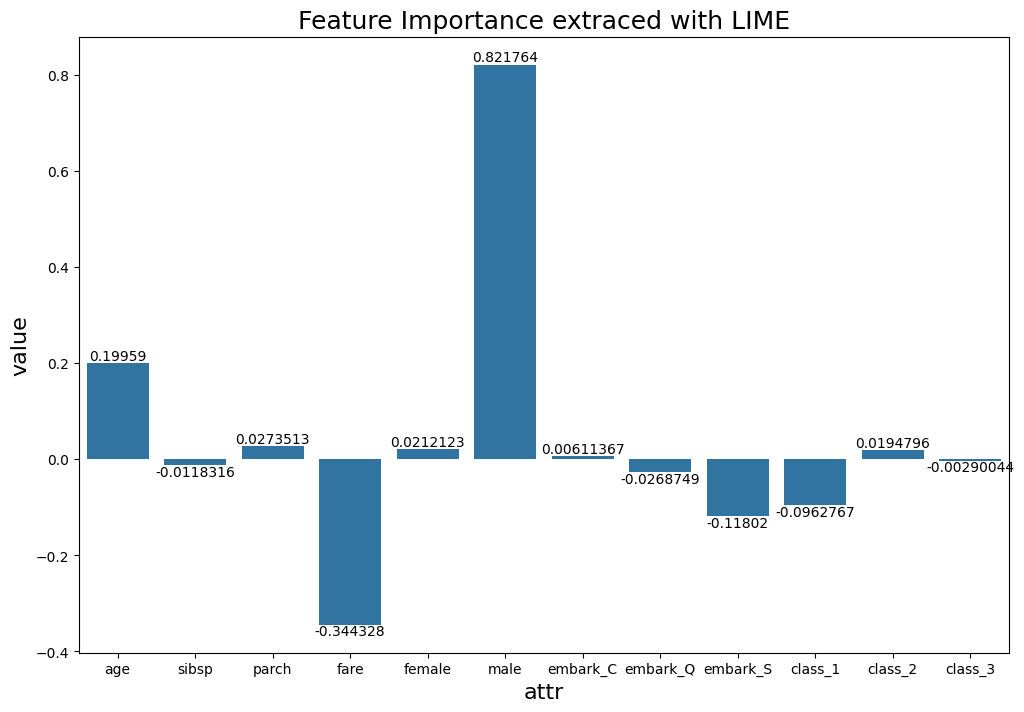

In [ ]:
import seaborn as sns
attr_df = pd.DataFrame(data, columns=['value', 'attr'])

print('Target Label: {},\nPredicted Label {}, with confidence score {}'.format(y_train[idx].item(),
                                                                              model(X_train[idx].view(1, -1)).argmax().item(),
                                                                              model(X_train[idx].view(1, -1))[0][model(X_train[idx].view(1, -1)).argmax().item()]))

plt.figure(figsize = (12,8))
ax = sns.barplot(x='attr', y='value', data = attr_df)
ax.bar_label(ax.containers[0])
ax.set(title='Feature Importance extraced with LIME')


The second implementation of LIME is LimeBase.

LimeBase provides a generic framework to train a surrogate interpretable model. This differs from most other attribution methods, since the method returns a representation of the interpretable model (e.g. coefficients of the linear model). For a similar interface to other perturbation-based attribution methods, please use the Lime child class, which defines specific transformations for the interpretable model.

LimeBase allows sampling points in either the interpretable space or the original input space to train the surrogate model. The interpretable space is a feature vector used to train the surrogate interpretable model; this feature space is often of smaller dimensionality than the original feature space in order for the surrogate model to be more interpretable.

If sampling in the interpretable space, a transformation function must be provided to define how a vector sampled in the interpretable space can be transformed into an example in the original input space. If sampling in the original input space, a transformation function must be provided to define how the input can be transformed into its interpretable vector representation.

In [ ]:

net = model

# We will train an interpretable model with the same
# features by simply sampling with added Gaussian noise
# to the inputs and training a model to predict the
# score of the target class.

# For interpretable model training, we will use sklearn
# linear model in this example. We have provided wrappers
# around sklearn linear models to fit the Model interface.
# Any arguments provided to the sklearn constructor can also
# be provided to the wrapper, e.g.:
# SkLearnLinearModel("linear_model.Ridge", alpha=2.0)
from captum._utils.models.linear_model import SkLearnLinearModel

# Define similarity kernel (exponential kernel based on L2 norm)
def similarity_kernel(
    original_input: torch.Tensor,
    perturbed_input: torch.Tensor,
    perturbed_interpretable_input: torch.Tensor,
    **kwargs)->torch.Tensor:
        # kernel_width will be provided to attribute as a kwarg
        kernel_width = kwargs["kernel_width"]
        l2_dist = torch.norm(original_input - perturbed_input)
        return torch.exp(- (l2_dist**2) / (kernel_width**2))


# Define sampling function
# This function samples in original input space
def perturb_func(
    original_input: torch.Tensor,
    **kwargs)->torch.Tensor:
        return original_input + torch.randn_like(original_input)

# For this example, we are setting the interpretable input to
# match the model input, so the to_interp_rep_transform
# function simply returns the input. In most cases, the interpretable
# input will be different and may have a smaller feature set, so
# an appropriate transformation function should be provided.

def to_interp_transform(curr_sample, original_inp,
                                     **kwargs):
    return curr_sample

# Generating random input with size 1 x 5
input = X_train[idx].view(1, -1)
target = y_train[idx].item()
# Defining LimeBase interpreter
lime_attr = LimeBase(net,
                         SkLearnLinearModel("linear_model.Ridge"),
                         similarity_func=similarity_kernel,
                         perturb_func=perturb_func,
                         perturb_interpretable_space=False,
                         from_interp_rep_transform=None,
                         to_interp_rep_transform=to_interp_transform)
# Computes interpretable model, returning coefficients of linear
# model.
attr_coefs = lime_attr.attribute(input, target=target, kernel_width=1.1)

In [ ]:
attr_coefs

tensor([[ 0.0161, -0.0177, -0.0029, -0.0075,  0.0157, -0.0155, -0.0028,  0.0271,
         -0.0059, -0.0059,  0.0171,  0.0044]])

## Interpreting MLP with SHAP

SHAP is one of the most powerful tool in ML explainability.

Check ['A unified Approach to Interpreting Model Predictions'](https://arxiv.org/pdf/1705.07874.pdf) for a better understanding.

SHAP values are based on Shapley values, a concept coming from game theory. But game theory needs at least two things: a game and some players. How does this apply to machine learning explainability? Imagine that we have a predictive model, then:
- the “game” is reproducing the outcome of the model,
- the “players” are the features included in the model.

What Shapley does is quantifying the contribution that each player brings to the game == **What SHAP does is quantifying the contribution that each feature brings to the prediction made by the model**.

It is important to stress that what we called a “game” concerns a single observation. **One game: one observation**. Indeed, SHAP is about local interpretability of a predictive model.

### Additive Feature Attribution Methods
SHAP belong to a class of attribution methdos known as additive feature attribution methods. Additive Festure Attribution Methods use an explanation model that is a linear function of binary variables:

$$g(z')=\phi_0+\sum_{i=1}^{M}\phi_iz_i'$$

where $z'\in\{0, 1\}^M$ and M is the number of simplified input features and $\phi_i \in \mathbb{R}$.

Methods that have an explanation model that match the previous equation attribute an effect $\phi_i$ to each feature, and summing the effects to all feature attributions approximate the outptu f(x) of the original model.

Explanation models often use simplified inputs $x′$ that map to the original inputs through a mapping function $x = h_x(x′)$. Local methods try to ensure $g(z′) ≈ f(h_x(z′))$ whenever $z′ ≈ x′$.

**LIME** is an example of additive feature attribution methods.

#### DeepLIFT

Another example is **DeepLIFT**. DeepLIFT is as a recursive prediction explanation method for deep learning. It attributes to each input $x_i$ a value $C_{\Delta_{x_i}\Delta_y}$ that represents the effect of that input being set to a reference value as opposed to its original value. This means that for DeepLIFT, the mapping $x = h_x(x′)$ converts binary values into the original inputs, where 1 indicates that an input takes its original value, and 0 indicates that it takes the reference value. The reference value, though chosen by the user, represents a typical uninformative background value for the feature.
DeepLIFT uses a "summation-to-delta" property that states:
$$\sum_{i=1}^{n}C_{\Delta_{x_i}\Delta_o}=\Delta_o$$

where $o = f(x)$ is the model output, $\Delta_o = f(x) − f(r), \Delta_{x_i} = x_i − r_i$, and r is the reference input. If we let $\phi_i = \Delta_{x_i}\Delta_o$ and $\phi_0 = f(r)$, then DeepLIFT’s explanation model matches the previous equation and is thus another additive feature attribution method.

#### SHAPLEY VALUE
Also the Shapley Values can be considered a case of additive feature attribution methods.

Formally, this method requires retraining the model on all feature subsets $S ⊆ F$, where F is the set of all features. It assigns an importance value to each feature that represents the effect on the model prediction of including that feature. To compute this effect, a model $f_{S∪\{i\}}$ is trained with that feature present, and another model $f_S$ is trained with the feature withheld. Then, predictions from the two models are compared on the current input $f_{S∪\{i\}}(x_{S∪\{i\}}) − f_{S}(x_S)$, where $x_S$ represents the values of the input features in the set S. Since the effect of withholding a feature depends on other features in the model, the preceding differences are computed for all possible subsets $S ⊆ F - \{i\}$. The Shapley values are then computed and used as feature attributions. They are a weighted average of all possible differences

$$\phi_i = \sum_{S⊆F - \{i\}}\frac{|S|!(|F|- |S| - 1)!}{|F|!}[f_{S∪\{i\}}(x_{S∪\{i\}}) − f_{S}(x_S)]$$

For Shapley regression values, $h_x$ maps 1 or 0 to the original input space, where 1 indicates the input is included in the model, and 0 indicates exclusion from the model. If we let $\phi_0 = f_∅(∅)$, then the Shapley regression values match the previous equation and are hence an additive feature attribution method.

The **Shapley Value Sampling** Algorithm is then ment to explain any model by:
- applying sampling approximations to the previous equation
- approximating the effect of removing a variable from the model by integrating over samples from the training dataset.

This eliminates the need to retrain the model and allows fewer differences to be computed.

### SHAP (SHapley Additive exPlanation) Values

In general additive feature attribution methods may have three properties:
- **Local Accuracy**: When approximating the original model f for a specific input x, local accuracy requires the explanation model to at least match the output of f for the simplified input x′ (which corresponds to the original input x).
- **Missingness**:  If the simplified inputs represent feature presence, then missing- ness requires features missing in the original input to have no impact.
- **Consistency**: If a model changes so that some simplified input’s contribution increases or stays the same regardless of the other inputs, that input’s attribution should not decrease.

It is possible to prove that there is only one possible explanation model g which is an additive feature attribution method that also satisfies these 3 Properties together.

$$\phi_i(f, x) = \sum_{z'⊆x' }\frac{|z'|!(M - |z'| - 1)!}{M!}[f_x(z') − f_x(z'-i)]$$

By setting $f_x(z') = f(h_x(z')) = E[f(z)|z_S]$, with S set of non-zero indexes in z', we get the Shapley Additive Explanation Values.


### Additive Feature Attribution Method with CAPTUM

There are many attribute methods in CAPTUM (check the [API References](https://captum.ai/api/index.html) for more information). In general they all share the same interface.

Firstly the algorithms must be instantiated taking the trained model as forward_function to be used to compute the model output.

Then we must call the attribute methods by passing the instance over which we want to build the explaination (remember that local models work on a single instance) and the target to comute the distance. The target must be expressed as an index if the problem is a classification problem or it must not be passed if the output of the model is a scalar, in case of a regression problem.

Some algorithms (as DeepLiftShap) also require some baseline to compute the distance between the surrogate model and the input data. This must be set accordingly.

In [ ]:
svs = ShapleyValueSampling(model)
dl = DeepLift(model)
dls = DeepLiftShap(model)
ks = KernelShap(model)

svs_attr_test = svs.attribute(X_test[0].view(1, -1), target=y_test[0].item())
dl_attr_test = dl.attribute(X_test[0].view(1, -1), target=y_test[0].item())

baseline = torch.cat([ X_test[1].view(1, -1)*0, X_test[2].view(1, -1)*1])
dls_attr_test = dls.attribute(X_test[0].view(1, -1), target=y_test[0].item(), baselines=baseline)

ks_attr_test = ks.attribute(X_test[0].view(1, -1), target=y_test[0].item())

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
ks_attr_test

tensor([[ 0.1074, -0.0661, -0.2156, -0.3085, -0.0256,  0.0689,  0.3082,  0.1835,
          0.0152,  0.0042, -0.0838,  0.0149]])

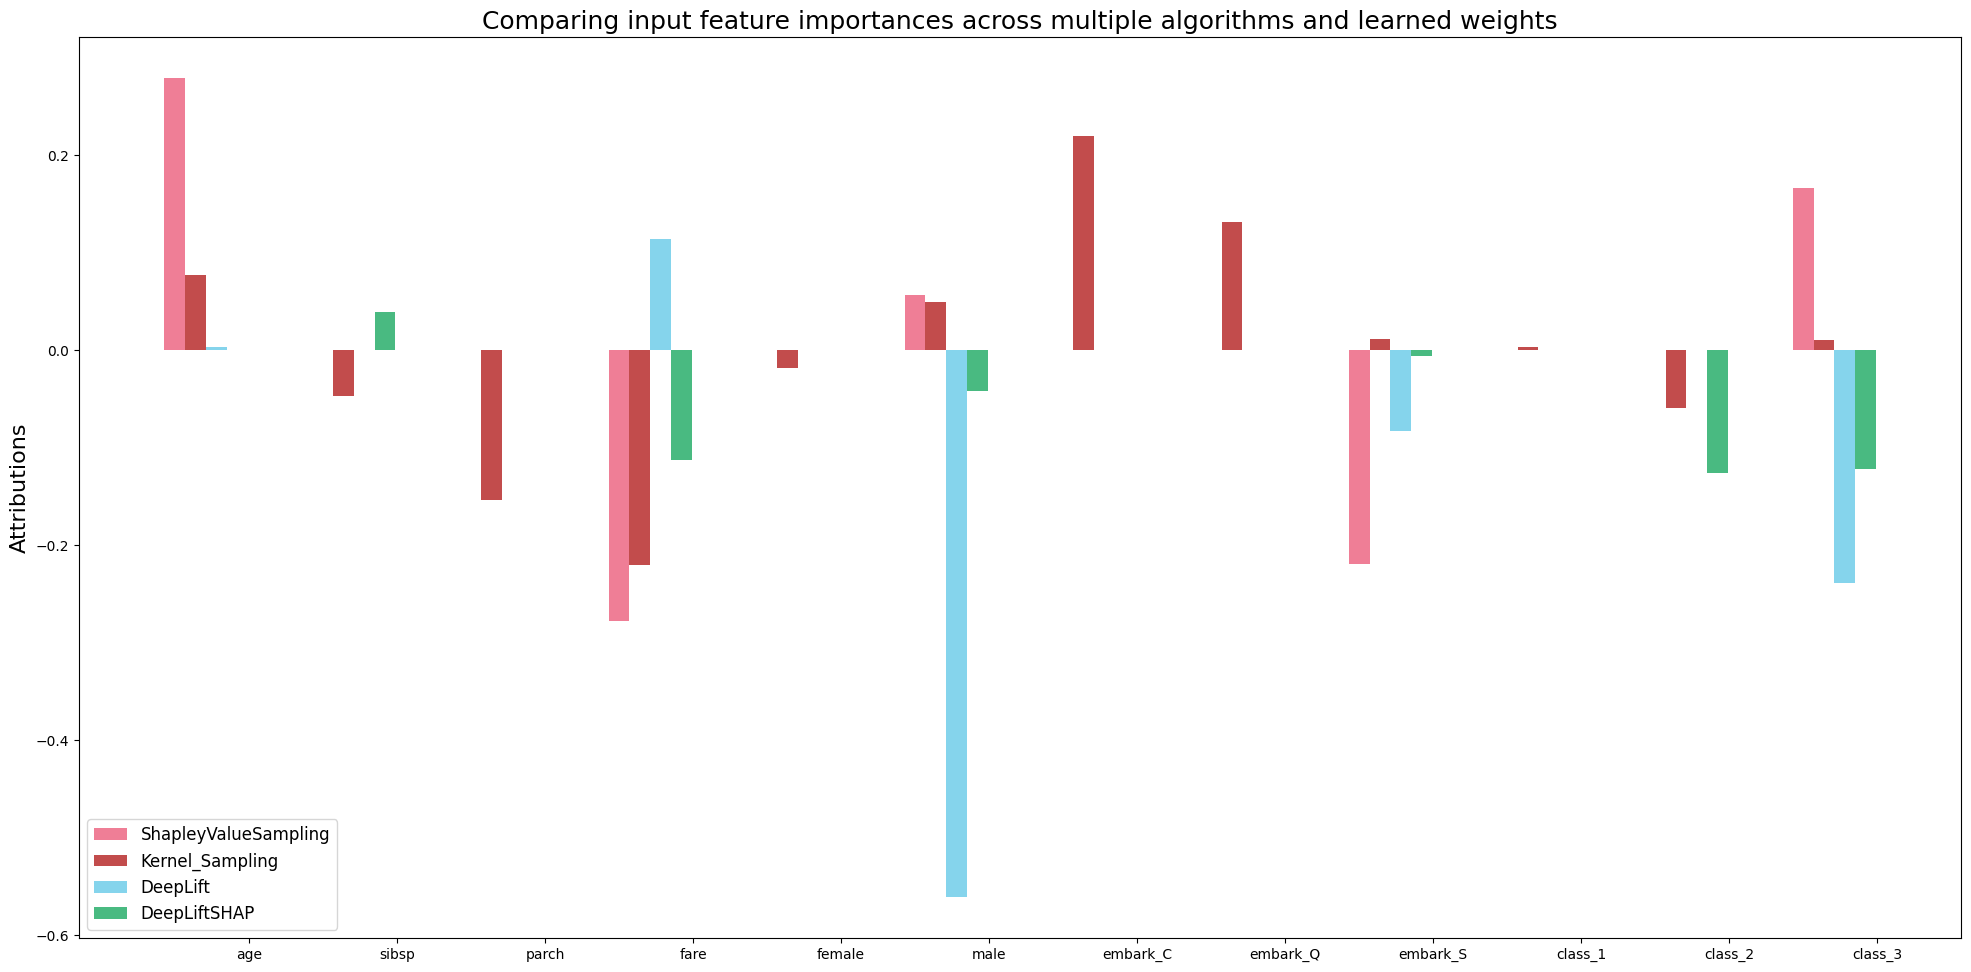

In [ ]:
# prepare attributions for visualization

feature_names = titanic_data.drop(['survived'], axis=1).columns

x_axis_data = np.arange(X_test.shape[1])
x_axis_data_labels = list(map(lambda idx: feature_names[idx], x_axis_data))

svs_attr_test_sum = svs_attr_test.detach().numpy().sum(0)
svs_attr_test_norm_sum = svs_attr_test_sum / np.linalg.norm(svs_attr_test_sum, ord=1)

dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
dl_attr_test_norm_sum = dl_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

dls_attr_test_sum = dls_attr_test.detach().numpy().sum(0)
dls_attr_test_norm_sum = dls_attr_test_sum / np.linalg.norm(dl_attr_test_sum, ord=1)

ks_attr_test_sum = ks_attr_test.detach().numpy().sum(0)
ks_attr_test_norm_sum = ks_attr_test_sum / np.linalg.norm(ks_attr_test_sum, ord=1)

width = 0.14
legends = ['ShapleyValueSampling', 'Kernel_Sampling', 'DeepLift', 'DeepLiftSHAP']

plt.figure(figsize=(20, 10))

ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')

FONT_SIZE = 16
plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data, svs_attr_test_norm_sum, width, align='center', alpha=0.8, color='#eb5e7c')
ax.bar(x_axis_data + width, ks_attr_test_norm_sum, width, align='center', alpha=0.7, color='#A90000')
ax.bar(x_axis_data + 2 * width, dl_attr_test_norm_sum, width, align='center', alpha=0.6, color='#34b8e0')
ax.bar(x_axis_data + 3 * width, dls_attr_test_norm_sum, width, align='center', alpha=1.0, color='#49ba81')

ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

plt.legend(legends, loc=3)
plt.show()

## LAB CHALLENGE 2: Explaining Recommender System

In the previous lecture we have built a recommender system using the Neural Matrix Factorization framework. This framework allowed us to combine the GMF layers with the MLP layers.

Let's focus on the MLP model:
<center>  <img src="https://drive.google.com/uc?export=view&id=1rL_8kkHIhSlQjWr8hNal4Tyog87-2kNP" width="550" height="350"> </center>

It easy to understand that the prediction is not computed over the user or the item indeces per se, but ove the embedding learned and produced. However such embeddings are latent features, which could be difficult to explain.

Let's try to add some information to our model, and let's try to understand whether and how such information may contribute to the final prediction.

In the dataset downloaded, we only focus on the u.data file. However, the dataset contains much more information. As an example, the u.item file contains information about the movies, like the tytle, the release date, the genre and also a link to the description of the movie. Similarly for the u.user file, which contains information about the age, the gender and the profession of the user.

Let's use these information in our model and then let's try to understand how they are used by the model to produce the final prediction.

HOW?


TASK 1: Starting from the MLP model (or the NMF if you prefer) modify the data handling structure in order to not only consider user and item index, but also the features of users and items. Then modify the structure of the MLP in order to let the model manage also these features. Try to suggest a possible way to integrate such information in the framework (do you know wide and deep architecture?). Once you are confident with the model, train it and compare the results with the baseline models. Is it better?

TASK 2: Apply LIME to the new MLP (or the new NMF) model. Mainly  focusing on the new introduced features. In doing it, you should probably modify the forward function, to consider as only input to be explained the new features. After getting the attributes of some input samples, tray to describe the results proposing your strategy for evaluating it.

[OPTIONAL] TASK 2-BIS: If you want, Try to understand if LIME can be applied also on the embedding of users and items using the InterpretableEmbeddingBase class

TASK 3: choose another additive feature attribution method and apply it to the new MLP (or NMF) model. Compare the results with the attributes obtained with LIME and provide some considerations.


Suggestion: a possible way to work on embedding is that of using  the InterpretableEmbeddingBase class. In particular, you can use the  configure_interpretable_embedding_layer method to create interpretation over the embedding layer. Pay attention to input and output dimensions of the surrogate model [This tutorial](https://captum.ai/tutorials/Multimodal_VQA_Interpret) may help you in better understanding this concept and, particularly, how to use additive feature models with embeddings.


# **OLD MLP MODEL**

This is the MLP model that we used in the assignment1. We can see the results of the old MLP and compare the results to the new MLP model.

In [ ]:
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
import os
import time
import random
import argparse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
np.random.seed(7)
torch.manual_seed(0)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
dataset_origin = {'100k': 'u.data', '1M': 'ratings.dat'}

num_sample_data = '100k'
DATA_PATH = '/content/drive/MyDrive/new-practice/ml-100k/{}'.format(dataset_origin[num_sample_data]) #change this with your directory
MODEL_PATH = '/content/drive/MyDrive/new-practice/ml-100k/{}'.format(num_sample_data) #change this with your directory

In [ ]:
class Rating_Dataset(Dataset):
	def __init__(self, user_list, item_list, rating_list):
		super(Rating_Dataset, self).__init__()
		self.user_list = user_list
		self.item_list = item_list
		self.rating_list = rating_list

	def __len__(self):
		return len(self.user_list)

	def __getitem__(self, idx):
		user = self.user_list[idx]
		item = self.item_list[idx]
		rating = self.rating_list[idx]

		return (
			torch.tensor(user, dtype=torch.long),
			torch.tensor(item, dtype=torch.long),
			torch.tensor(rating, dtype=torch.float)
			)

In [ ]:
class MLP_Data(object):
	"""
	Construct Dataset for MLP
	"""
	def __init__(self, args, ratings):
		self.ratings = ratings
		self.num_ng = args.num_ng
		self.num_ng_test = args.num_ng_test
		self.batch_size = args.batch_size

		self.preprocess_ratings = self._reindex(self.ratings)

		self.user_pool = set(self.ratings['user_id'].unique())
		self.item_pool = set(self.ratings['item_id'].unique())

		self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
		self.negatives = self._negative_sampling(self.preprocess_ratings)


	def _reindex(self, ratings):
		"""
		Process dataset to reindex userID and itemID, also set rating as binary feedback
		"""
		user_list = list(ratings['user_id'].drop_duplicates())
		user2id = {w: i for i, w in enumerate(user_list)}

		item_list = list(ratings['item_id'].drop_duplicates())
		item2id = {w: i for i, w in enumerate(item_list)}

		ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
		ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
		ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
		return ratings

	def _leave_one_out(self, ratings):
		"""
		leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
		"""
		ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
		test = ratings.loc[ratings['rank_latest'] == 1]
		train = ratings.loc[ratings['rank_latest'] > 1]
		assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
		return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]

	def _negative_sampling(self, ratings):
		interact_status = (
			ratings.groupby('user_id')['item_id']
			.apply(set)
			.reset_index()
			.rename(columns={'item_id': 'interacted_items'}))
		interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
		interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
		return interact_status[['user_id', 'negative_items', 'negative_samples']]

	def get_train_instance(self):
		users, items, ratings = [], [], []
		train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'negative_items']], on='user_id')
		train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
		for row in train_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in range(self.num_ng):
				users.append(int(row.user_id))
				items.append(int(row.negatives[i]))
				ratings.append(float(0))  # negative samples get 0 rating
		dataset = Rating_Dataset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)

	def get_test_instance(self):
		users, items, ratings = [], [], []
		test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
		for row in test_ratings.itertuples():
			users.append(int(row.user_id))
			items.append(int(row.item_id))
			ratings.append(float(row.rating))
			for i in getattr(row, 'negative_samples'):
				users.append(int(row.user_id))
				items.append(int(i))
				ratings.append(float(0))
		dataset = Rating_Dataset(
			user_list=users,
			item_list=items,
			rating_list=ratings)
		return DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=2)

In [ ]:
def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

In [ ]:
class MLP(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

    def init_weight(self):
        pass

In [ ]:
#collapse-hide
parser = argparse.ArgumentParser()
parser.add_argument("--seed",
	type=int,
	default=42,
	help="Seed")
parser.add_argument("--lr",
	type=float,
	default=0.001,
	help="learning rate")
parser.add_argument("--dropout",
	type=float,
	default=0.2,
	help="dropout rate")
parser.add_argument("--batch_size",
	type=int,
	default=256,
	help="batch size for training")
parser.add_argument("--epochs",
	type=int,
	default=20,
	help="training epoches")
parser.add_argument("--top_k",
	type=int,
	default=10,
	help="compute metrics@top_k")
parser.add_argument("--factor_num",
	type=int,
	default=32,
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+',
    default=[64,32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user \
    and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng",
	type=int,
	default=4,
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test",
	type=int,
	default=100,
	help="Number of negative samples for test set")
parser.add_argument("--out",
	default=True,
	help="save model or not")

_StoreAction(option_strings=['--out'], dest='out', nargs=None, const=None, default=True, type=None, choices=None, required=False, help='save model or not', metavar=None)

In [ ]:
# set device and parameters
args = parser.parse_args("")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# load data
ml_100k = pd.read_csv(
	DATA_PATH,
	sep="\t",
	names = ['user_id', 'item_id', 'rating', 'timestamp'],
	engine='python')

# set the num_users, items
num_users = ml_100k['user_id'].nunique()+1
num_items = ml_100k['item_id'].nunique()+1

# construct the train and test datasets
data = MLP_Data(args, ml_100k)
train_loader = data.get_train_instance()
test_loader = data.get_test_instance()

# set model and loss, optimizer
model = MLP(args, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs+1):
	model.train() # Enable dropout (if have).
	start_time = time.time()

	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss.backward()
		optimizer.step()
		#writer.add_scalar('loss/Train_loss', loss.item(), epoch)

	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)
	#writer.add_scalar('Perfomance/HR@10', HR, epoch)
	#writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

	elapsed_time = time.time() - start_time
	print("Epoch {:03d}".format(epoch) + " time to train: " +
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		if args.out:
			if not os.path.exists(MODEL_PATH):
				os.mkdir(MODEL_PATH)
			torch.save(model,
				'{}{}.pt'.format(MODEL_PATH, model.__class__.__name__))

<ipython-input-59-5b74b82250a8>:52: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, self.num_ng_test))
<ipython-input-59-5b74b82250a8>:58: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warn

Epoch 001 time to train: 00: 00: 44
HR: 0.399	NDCG: 0.218
Epoch 002 time to train: 00: 00: 27
HR: 0.396	NDCG: 0.221
Epoch 003 time to train: 00: 00: 28
HR: 0.400	NDCG: 0.227
Epoch 004 time to train: 00: 00: 26
HR: 0.392	NDCG: 0.220
Epoch 005 time to train: 00: 00: 29
HR: 0.394	NDCG: 0.225
Epoch 006 time to train: 00: 00: 40
HR: 0.415	NDCG: 0.230
Epoch 007 time to train: 00: 00: 36
HR: 0.426	NDCG: 0.240
Epoch 008 time to train: 00: 00: 34
HR: 0.452	NDCG: 0.254
Epoch 009 time to train: 00: 00: 35
HR: 0.470	NDCG: 0.262
Epoch 010 time to train: 00: 00: 35
HR: 0.501	NDCG: 0.277
Epoch 011 time to train: 00: 00: 36
HR: 0.505	NDCG: 0.284
Epoch 012 time to train: 00: 00: 39
HR: 0.499	NDCG: 0.280
Epoch 013 time to train: 00: 00: 34
HR: 0.517	NDCG: 0.287
Epoch 014 time to train: 00: 00: 38
HR: 0.512	NDCG: 0.293
Epoch 015 time to train: 00: 00: 32
HR: 0.526	NDCG: 0.295
Epoch 016 time to train: 00: 00: 35
HR: 0.533	NDCG: 0.303
Epoch 017 time to train: 00: 00: 39
HR: 0.526	NDCG: 0.296
Epoch 018 time

# **TASK1: NEW MLP MODEL**

TASK 1: Starting from the MLP model modify the data handling structure in order to not only consider user and item index, but also the features of users and items. Then modify the structure of the MLP in order to let the model manage also these features. Try to suggest a possible way to integrate such information in the framework. Model is trained it to compare the results with the baseline models.

In [ ]:
np.random.seed(7)
torch.manual_seed(0)

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [ ]:
# Defines the dataset_origin and DATA_PATH
dataset_origin = {'100k': {'data': 'u.data', 'item': 'u.item', 'user': 'u.user'}, '1M': {'data': 'ratings.dat', 'item': 'items.dat', 'user': 'users.dat'}}
num_sample_data = '100k'
data_type = 'data'
DATA_PATH = '/content/drive/MyDrive/new-practice/ml-100k/'

def load_data(file_name):
    file_path = f"{DATA_PATH}/{file_name}"
    if file_name == 'u.data':
        names = ['user_id', 'item_id', 'rating', 'timestamp']
    elif file_name == 'u.user':
        names = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
    elif file_name == 'u.item':
        names = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

    df = pd.read_csv(file_path, delimiter='\t' if file_name == 'u.data' else '|', names=names, encoding='latin1')
    return df

# Loads datasets
ratings_df = load_data('u.data')
users_df = load_data('u.user')
items_df = load_data('u.item')

In [ ]:
# Merges datasets
data = pd.merge(ratings_df, users_df, on='user_id')
data = pd.merge(data, items_df, on='item_id')

# Encodes categorical variables using One-Hot Encoding
encoder = OneHotEncoder(drop='first')
encoded_features = encoder.fit_transform(data[['gender', 'occupation']])
feature_names = encoder.get_feature_names_out(['gender', 'occupation'])

# Converts encoded features to a DataFrame and concatenate with data
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=feature_names)
data = pd.concat([data, encoded_df], axis=1)

data['release_year'] = pd.to_datetime(data['release_date']).dt.year.fillna(0).astype(int)
data.drop(['gender', 'occupation', 'zip_code', 'title', 'release_date', 'video_release_date', 'IMDb_URL'], axis=1, inplace=True)

# Splits the dataset into features and target variable
X = data.drop('rating', axis=1)
y = data['rating']
X.head()

,user_id,item_id,timestamp,age,unknown,Action,Adventure,Animation,Children,Comedy,...,occupation_none,occupation_other,occupation_programmer,occupation_retired,occupation_salesman,occupation_scientist,occupation_student,occupation_technician,occupation_writer,release_year
0,196,242,881250949,49,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1997
1,305,242,886307828,23,0,0,0,0,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1997
2,6,242,883268170,42,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997
3,234,242,891033261,60,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1997
4,63,242,875747190,31,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1997


In [ ]:
# Normalizes the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splits data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Converts data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Creates DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# MLP model with activation functions and dropout
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# Defines hyperparameters
input_size = X_train_tensor.shape[1]
hidden_size1 = 128
hidden_size2 = 64
learning_rate = 0.001
num_epochs = 20

# Initializes the model, loss function, and optimizer
model = MLP(input_size, hidden_size1, hidden_size2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluation after each epoch
    model.eval()
    test_loss = 0.0
    predictions = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs.squeeze(), targets).item()
            predictions.extend(outputs.squeeze().tolist())

    # Calculates HR@10 and NDCG@10 for the epoch
    def hit_rate_at_k(predicted_ratings, true_ratings, k):
        sorted_indices = np.argsort(predicted_ratings)[::-1][:k]
        top_items = [1 if true_ratings[i] >= 4 else 0 for i in sorted_indices]
        return sum(top_items) / k

    def ndcg_at_k(predicted_ratings, true_ratings, k):
        return ndcg_score([true_ratings], [predicted_ratings], k=k)

    hr_at_10 = hit_rate_at_k(predictions, y_test.values, 10)
    ndcg_at_10 = ndcg_at_k(predictions, y_test.values, 10)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Test Loss: {test_loss/len(test_loader)}, HR@10: {hr_at_10}, NDCG@10: {ndcg_at_10}')

Epoch 1/20, Loss: 1.7713558927774429, Test Loss: 1.1319229205131531, HR@10: 0.9, NDCG@10: 0.7945888761465525
Epoch 2/20, Loss: 1.3258313459873199, Test Loss: 1.126025127696991, HR@10: 0.9, NDCG@10: 0.8562709565844046
Epoch 3/20, Loss: 1.2231384754657746, Test Loss: 1.1211804275512696, HR@10: 0.7, NDCG@10: 0.7696657879931038
Epoch 4/20, Loss: 1.1728879509806633, Test Loss: 1.1123889560222626, HR@10: 1.0, NDCG@10: 0.9312606617215708
Epoch 5/20, Loss: 1.1459223960876466, Test Loss: 1.1139882318973542, HR@10: 0.9, NDCG@10: 0.8693706609392435
Epoch 6/20, Loss: 1.1354971200704576, Test Loss: 1.1144884311676024, HR@10: 0.8, NDCG@10: 0.8889833109441271
Epoch 7/20, Loss: 1.1244791563749312, Test Loss: 1.1053902613639832, HR@10: 0.9, NDCG@10: 0.8488399080003002
Epoch 8/20, Loss: 1.1150532513022422, Test Loss: 1.109481538915634, HR@10: 0.8, NDCG@10: 0.8379914071441864
Epoch 9/20, Loss: 1.111498880469799, Test Loss: 1.10291031126976, HR@10: 0.8, NDCG@10: 0.8489872673472417
Epoch 10/20, Loss: 1.106

The new MLP model significantly outperforms the old model in terms of key performance metrics, demonstrating a notable improvement in recommendation quality. Across 20 epochs, the new model achieves higher Hit Rates consistently around 0.8 to 1.0 and significantly better NDCG values, reaching up to 0.93. In contrast, the old model's HR peaks at 0.541 and NDCG at 0.306. The new model also shows a clear decreasing trend in both training and test loss, indicating effective learning and generalization

# **TASK2: Adding LIME**

We applied LIME to the new MLP model. Mainly focusing on the new introduced features.

In [ ]:
!pip install lime

Epoch 1/20, Loss: 4008911166350.7505, Test Loss: 1.3643662775993348, HR@10: 0.4, NDCG@10: 0.7047608948675995
Epoch 2/20, Loss: 1.352777007842064, Test Loss: 1.3708196837425233, HR@10: 0.4, NDCG@10: 0.6894710050367027
Epoch 3/20, Loss: 1.3679972755432128, Test Loss: 1.4111841361045838, HR@10: 0.4, NDCG@10: 0.6719329738858388
Epoch 4/20, Loss: 1.441840433573723, Test Loss: 1.3810813194274902, HR@10: 0.3, NDCG@10: 0.6040256024656196
Epoch 5/20, Loss: 1.9664344661235809, Test Loss: 2.2639159635543824, HR@10: 0.4, NDCG@10: 0.6465276602641092
Epoch 6/20, Loss: 1.4762810864448548, Test Loss: 1.6529516050338746, HR@10: 0.4, NDCG@10: 0.6202988862478794
Epoch 7/20, Loss: 2.795083359324932, Test Loss: 17.133707334899903, HR@10: 0.7, NDCG@10: 0.76065952653015
Epoch 8/20, Loss: 774948.9587919848, Test Loss: 20377.506940625, HR@10: 0.6, NDCG@10: 0.6556026176174231
Epoch 9/20, Loss: 281301.53754106676, Test Loss: 1.3089165685653688, HR@10: 0.4, NDCG@10: 0.6740955441553987
Epoch 10/20, Loss: 41944.615

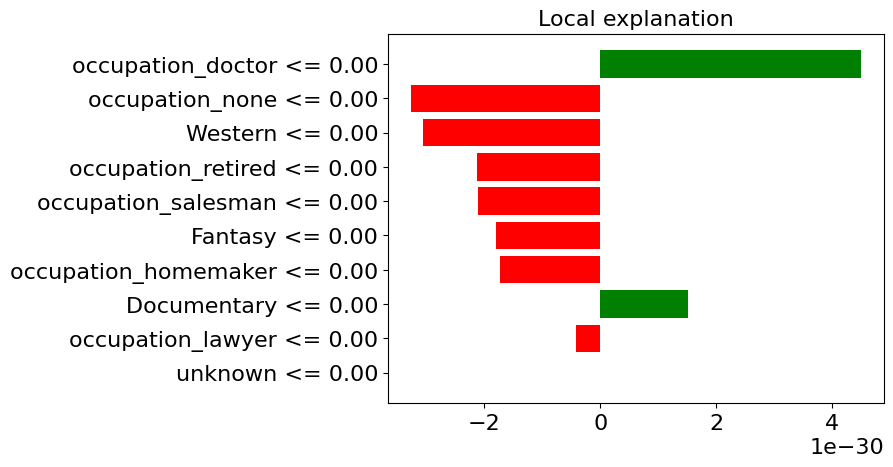

In [ ]:
from lime import lime_tabular

# Defines the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

# Load and preprocess the data
def load_data(file_name):
    file_path = f"{DATA_PATH}/{file_name}"
    if file_name == 'u.data':
        names = ['user_id', 'item_id', 'rating', 'timestamp']
    elif file_name == 'u.user':
        names = ['user_id', 'age', 'gender', 'occupation', 'zip_code']
    elif file_name == 'u.item':
        names = ['item_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

    df = pd.read_csv(file_path, delimiter='\t' if file_name == 'u.data' else '|', names=names, encoding='latin1')
    return df

# Set paths and seeds
DATA_PATH = '/content/drive/MyDrive/new-practice/ml-100k/'
np.random.seed(7)
torch.manual_seed(0)

# Load datasets
ratings_df = load_data('u.data')
users_df = load_data('u.user')
items_df = load_data('u.item')

# Merge datasets
data = pd.merge(ratings_df, users_df, on='user_id')
data = pd.merge(data, items_df, on='item_id')

# Encode categorical features
encoder = OneHotEncoder(drop='first')
encoded_features = encoder.fit_transform(data[['gender', 'occupation']])
feature_names = encoder.get_feature_names_out(['gender', 'occupation'])
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=feature_names)
data = pd.concat([data, encoded_df], axis=1)

# Feature engineering
data['release_year'] = pd.to_datetime(data['release_date']).dt.year.fillna(0).astype(int)
data.drop(['gender', 'occupation', 'zip_code', 'title', 'release_date', 'video_release_date', 'IMDb_URL'], axis=1, inplace=True)

# Split data into features and target
X = data.drop('rating', axis=1)
y = data['rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[1]
hidden_size1 = 128
hidden_size2 = 64
learning_rate = 0.01
num_epochs = 20

model = MLP(input_size, hidden_size1, hidden_size2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Evaluation after each epoch
    model.eval()
    test_loss = 0.0
    predictions = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs.squeeze(), targets).item()
            predictions.extend(outputs.squeeze().tolist())

    hr_at_10 = hit_rate_at_k(predictions, y_test.values, 10)
    ndcg_at_10 = ndcg_at_k(predictions, y_test.values, 10)

    # Print metrics
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Test Loss: {test_loss/len(test_loader)}, HR@10: {hr_at_10}, NDCG@10: {ndcg_at_10}')

    # Step the scheduler
    scheduler.step(test_loss)

# Define the predict function for LIME
def predict_fn(x):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(x, dtype=torch.float32).to(device)
        outputs = model(inputs).cpu().numpy()
    return outputs

# Use LIME to explain predictions
explainer = lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['rating'], verbose=True, mode='regression')

# Select an instance to explain
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=10)


# Plot the explanation
exp.as_pyplot_figure()
plt.show()


The LIME plot explains a prediction made by trained MLP model on the MovieLens dataset, showing which features most influenced the predicted movie rating. Positive contributions (green bars) like occupation_doctor and Documentary suggest these features increase the rating, while negative contributions (red bars) like occupation_none and Western decrease it. The training log indicates the model's learning progress across 20 epochs, with metrics like training loss, test loss, HR@10, and NDCG@10 evaluating performance. LIME's local explanation helps in understanding and interpreting the model's decisions by highlighting the most impactful features for an individual prediction.







# **TASK3: Implementing SHAP**

In [ ]:
!pip install shap
!pip install captum

In [ ]:
pip install --upgrade captum

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


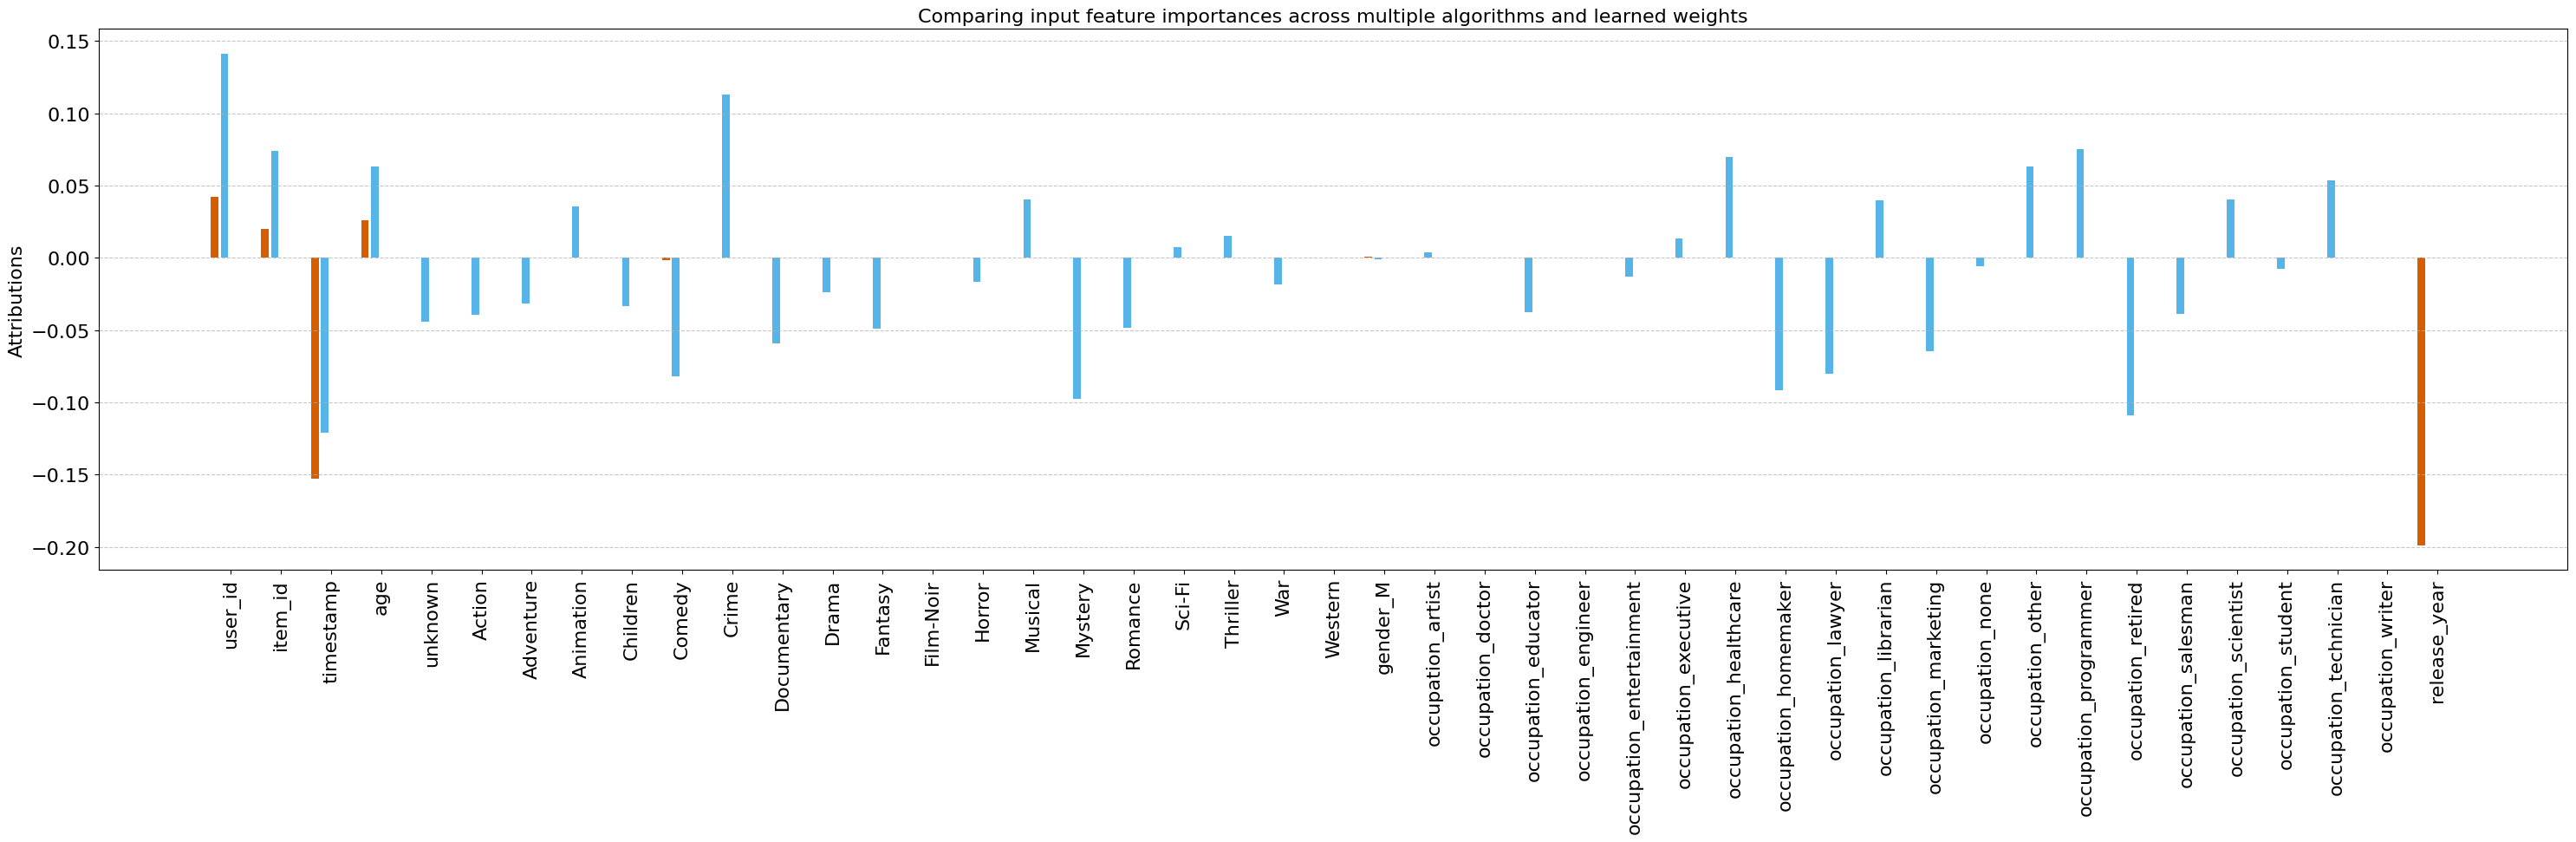

In [ ]:
import shap
from captum.attr import DeepLift, ShapleyValueSampling, KernelShap, DeepLiftShap

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


import warnings

# Suppress' specific warnings
warnings.filterwarnings(
    'ignore',
    category=UserWarning,
    message='Input Tensor 0 did not already require gradients, required_grads has been set automatically.'
)
warnings.filterwarnings(
    'ignore',
    category=UserWarning,
    message='Setting forward, backward hooks and attributes on non-linear activations. The hooks and attributes will be removed after the attribution is finished.'
)

# Defines a simplified MLP model
class SimplifiedMLP(nn.Module):
    def __init__(self, input_size):
        super(SimplifiedMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # Reduced complexity
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)           # Fewer layers
        self.Sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        output = self.Sigmoid(self.fc2(x))
        output = torch.relu(self.fc3(output))  # Final output
        return output

# Prepares the input data and initialize the model
X_train_np = X_train_tensor.numpy()
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
input_size = X_train_tensor.shape[1]

simplified_model = SimplifiedMLP(input_size)

# Converts DataFrame or Series to tensor if necessary
if isinstance(X_test_tensor, pd.DataFrame):
    X_test_tensor = torch.tensor(X_test_tensor.values, dtype=torch.float32)
if isinstance(y_test, pd.Series):
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

# Samples for explanation
sample_index = 0
X_test_sample = X_test_tensor[sample_index].view(1, -1)
y_test_sample = y_test[sample_index].item()

# Sets the model in evaluation mode
simplified_model.eval()

# Ensures the test sample has gradients enabled
X_test_sample.requires_grad_(True)

# SHAP and Captum explainers
explainer_gradient = shap.GradientExplainer(simplified_model, X_train_tensor)
gradient_shap_values = explainer_gradient.shap_values(X_test_sample)

# Initializes Captum explainers
svs = ShapleyValueSampling(simplified_model)
ks = KernelShap(simplified_model)
dl = DeepLift(simplified_model)

# Computes attributions
svs_attr_test = svs.attribute(X_test_sample, target=0)
ks_attr_test = ks.attribute(X_test_sample, target=0)
dl_attr_test = dl.attribute(X_test_sample, target=0)

# Prepares attributions for visualization
feature_names = X.columns  # Make sure X has column names
x_axis_data = np.arange(X_test_sample.shape[1])

# Checks if feature_names is not empty
x_axis_data_labels = [feature_names[idx] for idx in x_axis_data] if not feature_names.empty else ['Feature ' + str(i) for i in range(len(x_axis_data))]

# Normalizes attributions to compare
svs_attr_test_sum = svs_attr_test.detach().numpy().sum(0)
dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
ks_attr_test_sum = ks_attr_test.detach().numpy().sum(0)

# Clips extreme values for better visualization
clip_value = 0.5
svs_attr_test_sum = np.clip(svs_attr_test_sum, -clip_value, clip_value)
dl_attr_test_sum = np.clip(dl_attr_test_sum, -clip_value, clip_value)
ks_attr_test_sum = np.clip(ks_attr_test_sum, -clip_value, clip_value)
gradient_shap_values = np.clip(gradient_shap_values, -clip_value, clip_value)

plt.figure(figsize=(30, 10))
ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')
plt.xticks(rotation=90)  # Rotates labels for better visibility
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=16)

# Adjusts bar width and spacing for clarity
num_methods = 4
bar_width = 0.15
spacing = 0.05
group_width = num_methods * (bar_width + spacing)
group_spacing = 0.3

colors = ['#D55E00', '#56B4E9', '#009E73', '#F0E442']
labels = ['ShapleyValueSampling', 'KernelShap', 'DeepLift', 'GradientExplainer']
data_sets = [svs_attr_test_sum, ks_attr_test_sum, dl_attr_test_sum, np.array(gradient_shap_values).reshape(-1)]

# Calculates positions for each group of bars
x_indices = np.arange(len(x_axis_data_labels))
start_pos = x_indices - (group_width - bar_width) / 2

for i, (color, label, data) in enumerate(zip(colors, labels, data_sets)):
    ax.bar(start_pos + i * (bar_width + spacing), data, bar_width, label=label, color=color)

ax.set_xticks(x_indices)
ax.set_xticklabels(x_axis_data_labels)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better value assessment
plt.tight_layout()
plt.show()


The graph compares feature importances across multiple explainability algorithms for a simplified MLP (Multi-Layer Perceptron) model. The x-axis lists the dataset features, including user attributes, movie genres, and occupations, while the y-axis represents the SHAP values (attributions). Positive values indicate a positive contribution to the prediction, while negative values indicate a negative contribution. Different colors represent different explainability methods (Shapley Value Sampling, Kernel SHAP, DeepLift, Gradient Explainer).

Key observations include high positive attributions for features like item_id, Adventure, and occupation_writer, and high negative attributions for age and occupation_lawyer. Consistent attributions across methods for features like item_id and Adventure indicate robust importance, while variations in attributions for some features highlight the need for further investigation. SHAP is used in the code to provide interpretable explanations of the model's predictions, ensuring fair attribution of feature importance and aiding in model debugging and trust-building.

/usr/local/lib/python3.10/dist-packages/captum/attr/_core/deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


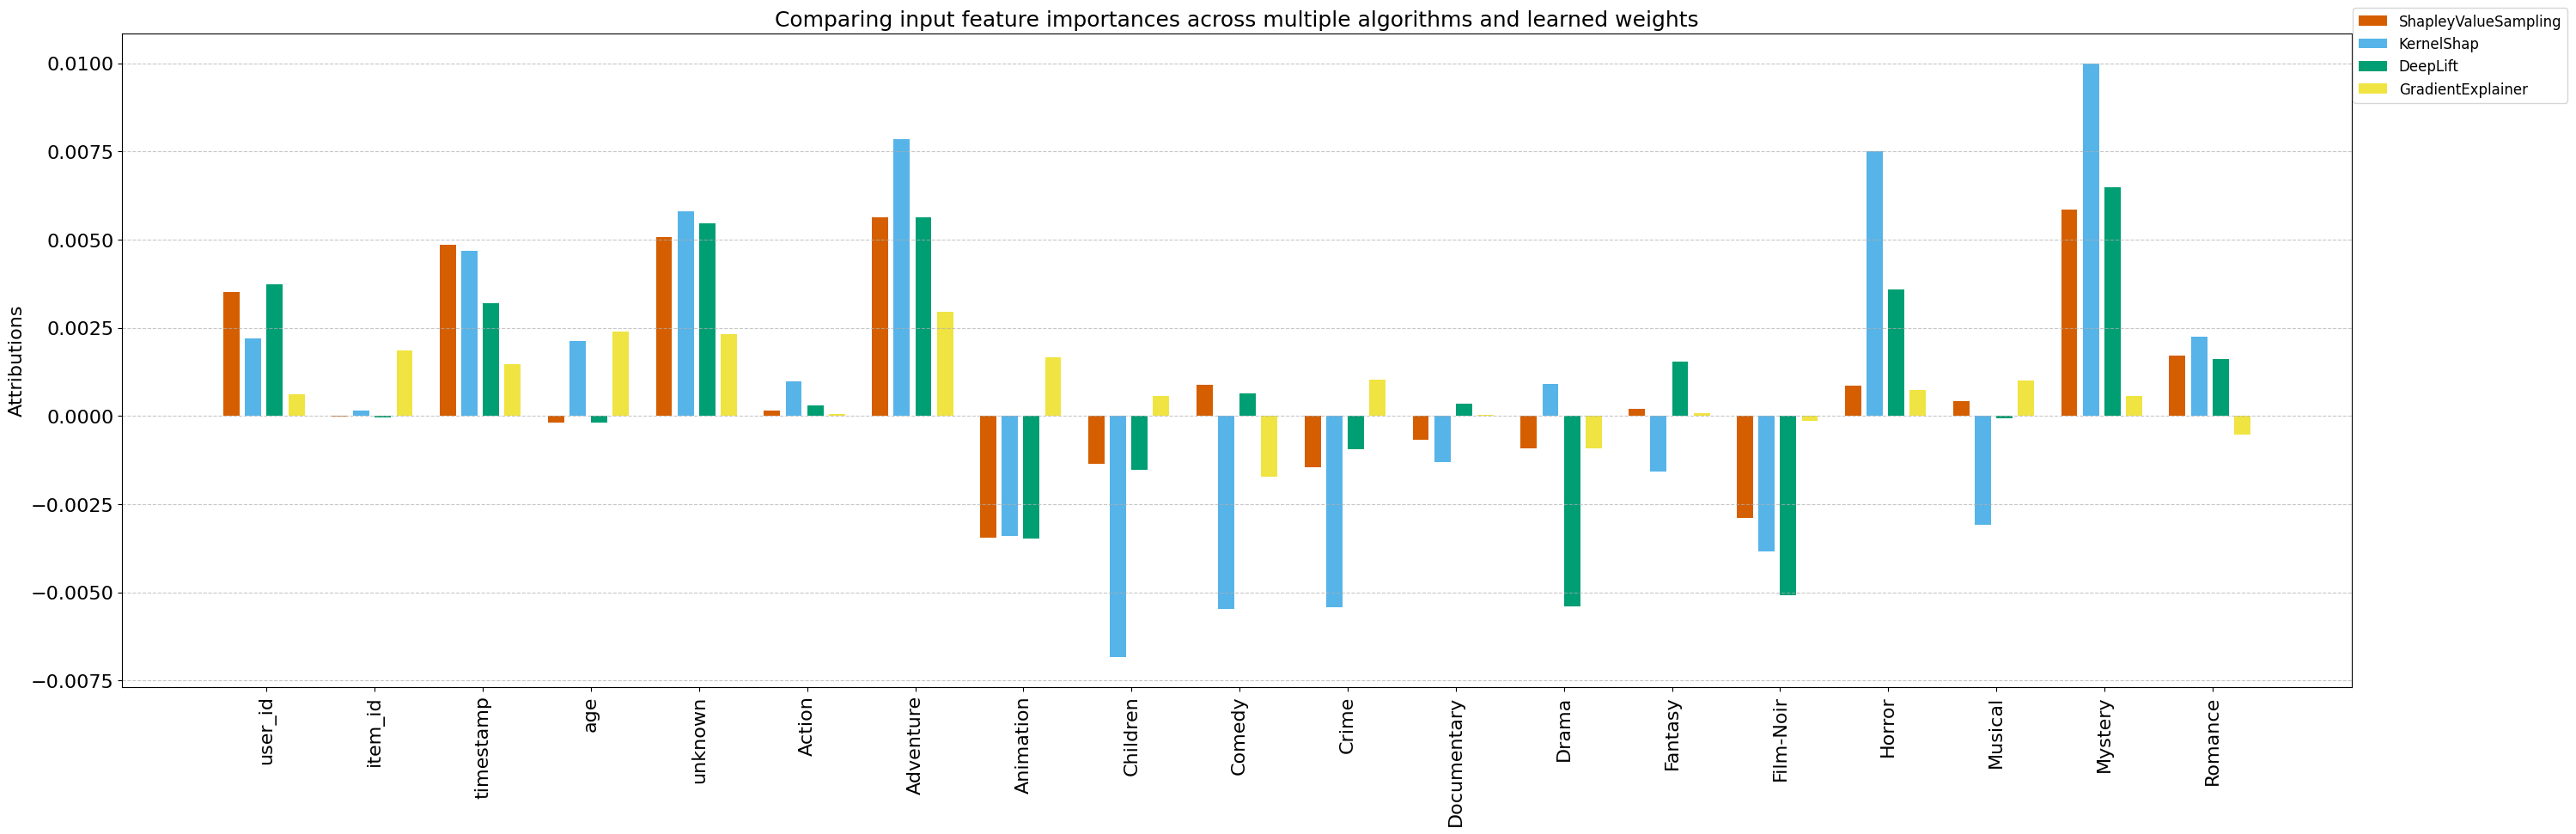

In [ ]:
# Sets the seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Suppress' specific warnings
import warnings
warnings.filterwarnings(
    'ignore',
    category=UserWarning,
    message='Input Tensor 0 did not already require gradients, required_grads has been set automatically.'
)
warnings.filterwarnings(
    'ignore',
    category=UserWarning,
    message='Setting forward, backward hooks and attributes on non-linear activations. The hooks and attributes will be removed after the attribution is finished.'
)

# Defines a simplified MLP model
class SimplifiedMLP(nn.Module):
    def __init__(self, input_size):
        super(SimplifiedMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Prepares the input data and initialize the model
X_train_np = np.random.rand(100, 19)  # Example data with 19 features
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_test_np = np.random.rand(20, 19)  # Example data with 19 features
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)
y_test_np = np.random.randint(0, 2, size=(20,))  # Example data
y_test = torch.tensor(y_test_np, dtype=torch.float32)

feature_names = [
    'user_id', 'item_id', 'timestamp', 'age', 'unknown', 'Action',
    'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary',
    'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance'
]
X = pd.DataFrame(X_train_np, columns=feature_names)

input_size = X_train_tensor.shape[1]
simplified_model = SimplifiedMLP(input_size)

#Converts DataFrame or Series to tensor if necessary
if isinstance(X_test_tensor, pd.DataFrame):
    X_test_tensor = torch.tensor(X_test_tensor.values, dtype=torch.float32)
if isinstance(y_test, pd.Series):
    y_test = torch.tensor(y_test.values, dtype=torch.float32)

sample_index = 0
X_test_sample = X_test_tensor[sample_index].view(1, -1)
y_test_sample = y_test[sample_index].item()

simplified_model.eval()

X_test_sample.requires_grad_(True)

# SHAP and Captum explainers
explainer_gradient = shap.GradientExplainer(simplified_model, X_train_tensor)
gradient_shap_values = explainer_gradient.shap_values(X_test_sample)

# Initialize Captum explainers
svs = ShapleyValueSampling(simplified_model)
ks = KernelShap(simplified_model)
dl = DeepLift(simplified_model)

# Computes attributions
svs_attr_test = svs.attribute(X_test_sample, target=0)
ks_attr_test = ks.attribute(X_test_sample, target=0)
dl_attr_test = dl.attribute(X_test_sample, target=0)

# Prepares attributions for visualization
x_axis_data_labels = feature_names

# Normalizes attributions to compare
svs_attr_test_sum = svs_attr_test.detach().numpy().sum(0)
dl_attr_test_sum = dl_attr_test.detach().numpy().sum(0)
ks_attr_test_sum = ks_attr_test.detach().numpy().sum(0)

# Clips extreme values for better visualization
clip_value = 0.01
svs_attr_test_sum = np.clip(svs_attr_test_sum, -clip_value, clip_value)
dl_attr_test_sum = np.clip(dl_attr_test_sum, -clip_value, clip_value)
ks_attr_test_sum = np.clip(ks_attr_test_sum, -clip_value, clip_value)
gradient_shap_values = np.clip(gradient_shap_values, -clip_value, clip_value)

plt.figure(figsize=(30, 10))
ax = plt.subplot()
ax.set_title('Comparing input feature importances across multiple algorithms and learned weights')
ax.set_ylabel('Attributions')
plt.xticks(rotation=90)  #Rotates labels for better visibility
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=16)

# Adjusts bar width and spacing for clarity
num_methods = 4
bar_width = 0.15
spacing = 0.05
group_width = num_methods * (bar_width + spacing)
group_spacing = 0.3

colors = ['#D55E00', '#56B4E9', '#009E73', '#F0E442']
labels = ['ShapleyValueSampling', 'KernelShap', 'DeepLift', 'GradientExplainer']
data_sets = [svs_attr_test_sum, ks_attr_test_sum, dl_attr_test_sum, np.array(gradient_shap_values).reshape(-1)]

# Calculates positions for each group of bars
x_indices = np.arange(len(x_axis_data_labels))
start_pos = x_indices - (group_width - bar_width) / 2

for i, (color, label, data) in enumerate(zip(colors, labels, data_sets)):
    ax.bar(start_pos + i * (bar_width + spacing), data, bar_width, label=label, color=color)

ax.set_xticks(x_indices)
ax.set_xticklabels(x_axis_data_labels)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The code uses SHAP to explain predictions of a simplified MLP model by computing feature attributions. The graph shows feature importances using different methods (Shapley Value Sampling, Kernel SHAP, DeepLift, Gradient Explainer), with positive values indicating positive contributions to predictions and negative values indicating negative contributions. Key observations include significant positive attributions for Action, Adventure, and Horror, and negative attributions for Children and Crime. Consistency in attributions across methods for features like Action and Adventure indicates robust importance, while variations highlight areas needing further investigation.